## Data generation

In [5]:
## common parameters and imports

import numpy as np
import pandas as pd
import zfit
import mplhep as hep
import matplotlib.pyplot as plt
import random

# Set a seed for reproducibility (so every student gets the same data)
np.random.seed(42)

# --- Configuration ---
# True Physics Parameters
BR_true = 5.8e-6 
alpha_Ds = 2.5e-9
alpha_Dp = 8.0e-9

# Yields
N_sig_Ds = int(BR_true / alpha_Ds) # ~2320 events
N_sig_Dp = int(BR_true / alpha_Dp) # ~725 events

# Mass Parameters (MeV)
m_Ds = 1968.0
m_Dp = 1869.6
m_eta = 547.8

# Resolution (sigma)
sigma_D = 15.0
sigma_eta = 10.0

# Background Slopes (Exponential index)
slope_Ds_D = -0.002
slope_Dp_D = -0.003
slope_eta = -0.005


In [2]:

def generate_Ds_sample(n_sig, n_comb, n_peaking):
    # 1. Signal (Ds -> eta pi): Gaussian(Ds) * Gaussian(eta)
    sig_mD = np.random.normal(m_Ds, sigma_D, n_sig)
    sig_mEta = np.random.normal(m_eta, sigma_eta, n_sig)
    
    # 2. Combinatorial Bkg: Exponential(Ds) * Exponential(eta)
    bkg_mD = np.random.exponential(-1/slope_Ds_D, n_comb * 5) + 1800
    bkg_mD = bkg_mD[(bkg_mD > 1800) & (bkg_mD < 2100)][:n_comb]
    
    bkg_mEta = np.random.exponential(-1/slope_eta, n_comb * 5) + 500
    bkg_mEta = bkg_mEta[(bkg_mEta > 500) & (bkg_mEta < 600)][:n_comb]
    
    # 3. Peaking Bkg (Real eta, Fake Ds): Exponential(Ds) * Gaussian(eta)
    peak_mD = np.random.exponential(-1/slope_Ds_D, n_peaking * 5) + 1800
    peak_mD = peak_mD[(peak_mD > 1800) & (peak_mD < 2100)][:n_peaking]
    peak_mEta = np.random.normal(m_eta, sigma_eta, n_peaking)
    
    # Combine
    mD = np.concatenate([sig_mD, bkg_mD, peak_mD])
    mEta = np.concatenate([sig_mEta, bkg_mEta, peak_mEta])

    df = pd.DataFrame({"mass_D": mD, "mass_eta": mEta})
    # Shuffle
    return df.sample(frac=1).reset_index(drop=True)

def generate_Dp_sample(n_sig, n_comb, n_peaking):
    # 1. Signal (D+ -> eta pi): Gaussian(Dp) * Gaussian(eta)
    sig_mD = np.random.normal(m_Dp, sigma_D, n_sig)
    sig_mEta = np.random.normal(m_eta, sigma_eta, n_sig)
    
    # 2. Combinatorial Bkg: Exponential(Dp) * Exponential(eta)
    bkg_mD = np.random.exponential(-1/slope_Dp_D, n_comb * 5) + 1800
    bkg_mD = bkg_mD[(bkg_mD > 1800) & (bkg_mD < 2100)][:n_comb]
    
    bkg_mEta = np.random.exponential(-1/slope_eta, n_comb * 5) + 500
    bkg_mEta = bkg_mEta[(bkg_mEta > 500) & (bkg_mEta < 600)][:n_comb]
    
    # 3. Peaking Bkg (Real D+, Fake eta): Gaussian(Dp) * Exponential(eta)
    peak_mD = np.random.normal(m_Dp, sigma_D, n_peaking)
    peak_mEta = np.random.exponential(-1/slope_eta, n_peaking * 5) + 500
    peak_mEta = peak_mEta[(peak_mEta > 500) & (peak_mEta < 600)][:n_peaking]
    
    # Combine
    mD = np.concatenate([sig_mD, bkg_mD, peak_mD])
    mEta = np.concatenate([sig_mEta, bkg_mEta, peak_mEta])
    
    df = pd.DataFrame({"mass_D": mD, "mass_eta": mEta})
    return df.sample(frac=1).reset_index(drop=True)

# Generate and Save
df_Ds = generate_Ds_sample(n_sig=N_sig_Ds, n_comb=3000, n_peaking=500)
df_Dp = generate_Dp_sample(n_sig=N_sig_Dp, n_comb=2000, n_peaking=400)

df_Ds.to_csv("dataset_Ds.csv", index=False)
df_Dp.to_csv("dataset_Dp.csv", index=False)

print(f"Datasets generated:\n- dataset_Ds.csv ({len(df_Ds)} events)\n- dataset_Dp.csv ({len(df_Dp)} events)")

Datasets generated:
- dataset_Ds.csv (5820 events)
- dataset_Dp.csv (3125 events)


# Exercise:

You are analyzing data from a high-energy physics experiment (like LHCb). You are studying the rare decay of charmed mesons into an $\eta$ meson and a pion:

1. $D_s^+ \to \eta \pi^+$
2. $D^+ \to \eta \pi^+$

In both cases, the  meson is reconstructed via its dimuon decay mode: : $\eta \to \mu^+ \mu^-$.
Your physics objective is to measure the branching ratio $\mathcal{B}(\eta \to \mu^+\mu^-)$.
This branching ratio is a fundamental constant of nature and must be the **same** regardless of whether the $\eta$ meson came from a  $D_s^+$ or a $D^+$.

You have two [datasets](https://www.dropbox.com/scl/fi/xd5tn9444ggn307d7qzih/zfit_ex_datasets.zip?rlkey=vvfldbo1hjgaiapfhvtupolxr&dl=1): `dataset_Ds.csv` and `dataset_Dp.csv`. 


* **Sample A ($D^+_s$):** Events selected near the $D_s^+$ mass.
* **Sample B ($D^+$):** Events selected near the $D^+$ mass.

Instead of fitting $N_{sig}$ independently and calculating the Branching Ratio (BR) offline, you will perform a Simultaneous Fit to both samples. You will parameterize the signal yield $N_{sig}$ in the fit directly as a function of the physics parameter $\mathcal{B}(\eta \to \mu\mu)$ and a normalization factor $\alpha$ (which includes luminosity, cross-section, and efficiency).

$$\mathcal{B}(\eta \to \mu\mu) = N_{sig} \cdot \alpha \quad \Rightarrow \quad N_{sig}(\mathcal{B}) = \frac{\mathcal{B}}{\alpha}$$

You are given the sensitivity factors $\alpha$ for each channel:

$\alpha_{D^+_s} = 2.5 \times 10^{-5}$

$\alpha_{D^+} = 8.0 \times 10^{-5}$


You are dealing with a 2D problem. The observables are:

1. `mass_D`: The invariant mass of the  $\mu\mu\pi$ system.
2. `mass_eta`: The invariant mass of the  $\mu\mu$ system.

This sample contains three components:

#### Sample 1:  $D_s^+$ Region

This sample contains three components:

1. **Signal ($D^+_s \to \eta \pi$):**
* `mass_D`: Gaussian (Peak at $m_{D^+_s}$).
* `mass_eta`: Gaussian (Peak at $m_\eta$).


2. **Combinatorial Background:**
* `mass_D`: Exponential.
* `mass_eta`: Exponential.


3. **Real $\eta$ Background (Fake $D^+_s$)**:
Contains a real $\eta$, but combined with a random pion:
* `mass_D`: Exponential  (No $D^+_s$ peak).
* `mass_eta`: Gaussian (Real $\eta$ peak).


#### Sample 2:  $D^+$ Region

This sample contains three components:

1. **Signal ($D^+ \to \eta \pi$):**
* `mass_D`: Gaussian (Peak at $m_{D^+}$).
* `mass_eta`: Gaussian (Peak at $m_\eta$).


2. **Combinatorial Background:**
* `mass_D`: Exponential.
* `mass_eta`: Exponential.

3. **Non-Resonant Background (Real $D^+$):**
Contains a real $D^+ \to \mu\mu\pi$ decay, but the muons are not from an $\eta$ meson.
* `mass_D`: Gaussian (Real $D^+$ peak).
* `mass_eta`: Exponential (No $\eta$ peak).


#### Tasks

1. **Model Building:** Construct the 2D PDFs for all 6 components (3 for , 3 for ) using `zfit`. Try to discuss the *meaning* or *origin* of each of the components mentioned above.
*Hint:* The Signal and the ``Real'' background must share the same  mass shape parameters. The centers of the gaussians should be roughly the masses of the relevant particles. You can assume their widths to the be in the range of 5-20 MeV. The background slopes are small and negative, in the $(-10^{-2},-10^{-3})$ range.
2. **Parameterization:** Create a shared parameter `BR_eta_mumu`. Define the signal yields for both samples as composed parameters dependent on this BR.
3. **Simultaneous Fit:** Perform a simultaneous fit to both datasets.
4. **Validation:** Plot the projections of the fit (Mass  and Mass ) for both samples.
5. **Result:** Result: Report the fitted value of $\mathcal{B}(\eta \to \mu\mu)$ and its uncertainty. Does it cover the true value?
6. **Discuss:** How does the precision you achieve in the BR compare to the current world best? How would you improve it? Is there any effect going into the BR uncertainty you are missing? 

## Analysis

In [6]:
# ==========================================
# Import datasets
# ==========================================

# Define the Observable Spaces
obs_D = zfit.Space("mass_D", limits=(1800, 2100))
obs_eta = zfit.Space("mass_eta", limits=(500, 600))
obs_2D = obs_D * obs_eta

# Convert to zfit Data
data_Ds = zfit.Data.from_pandas(df_Ds, obs=obs_2D)
data_Dp = zfit.Data.from_pandas(df_Dp, obs=obs_2D)

# Convert to zfit Data
data_Ds = zfit.Data.from_pandas(df_Ds, obs=obs_2D)
data_Dp = zfit.Data.from_pandas(df_Dp, obs=obs_2D)

print(f"Loaded Ds events: {data_Ds.n_events.numpy()}")
print(f"Loaded D+ events: {data_Dp.n_events.numpy()}")

# Set plotting style
plt.style.use(hep.style.ROOT)

Loaded Ds events: 5820
Loaded D+ events: 3125


In [10]:
# ==========================================
# Model Building
# ==========================================

# --- Shared Parameters ---
# The Parameter of Interest: Branching Ratio
br_eta_mumu = zfit.Parameter("BR_eta_mumu", 6e-6, 1e-6, 1e-5)

# D mass shapes
mu_Ds = zfit.Parameter("mu_Ds", 1968, 1950, 1980)
sigma_Ds = zfit.Parameter("sigma_Ds", 15, 5, 30)
lam_Ds_bkg = zfit.Parameter("lam_Ds_bkg", -0.002, -0.01, 0)

# D mass shapes
mu_Dp = zfit.Parameter("mu_Dp", 1870, 1850, 1890)
sigma_Dp = zfit.Parameter("sigma_Dp", 15, 5, 30)
lam_Dp_bkg = zfit.Parameter("lam_Dp_bkg", -0.003, -0.01, 0)

pdf_Dp_gauss = zfit.pdf.Gauss(mu=mu_Dp, sigma=sigma_Dp, obs=obs_D)
pdf_Dp_exp = zfit.pdf.Exponential(lambda_=lam_Dp_bkg, obs=obs_D)

pdf_Ds_gauss = zfit.pdf.Gauss(mu=mu_Ds, sigma=sigma_Ds, obs=obs_D)
pdf_Ds_exp = zfit.pdf.Exponential(lambda_=lam_Ds_bkg, obs=obs_D)

# Shared Eta shape parameters (Resolution is detector driven, should be same)
mu_eta = zfit.Parameter("mu_eta", 548, 540, 560)
sigma_eta = zfit.Parameter("sigma_eta", 10, 5, 20)

# Define eta PDF (reused multiple times)
pdf_eta_gauss = zfit.pdf.Gauss(mu=mu_eta, sigma=sigma_eta, obs=obs_eta)
pdf_eta_exp_Ds = zfit.pdf.Exponential(lambda_=zfit.Parameter("lam_eta_Ds", -0.005, -0.01, 0), obs=obs_eta)
pdf_eta_exp_Dp = zfit.pdf.Exponential(lambda_=zfit.Parameter("lam_eta_Dp", -0.005, -0.01, 0), obs=obs_eta)

# --- Sample 1: Ds Model ---

# 1. Define Components (Standard PDFs)
sig_Ds_2D = zfit.pdf.ProductPDF([pdf_Ds_gauss, pdf_eta_gauss])
comb_Ds_2D = zfit.pdf.ProductPDF([pdf_Ds_exp, pdf_eta_exp_Ds])
fakeDs_2D = zfit.pdf.ProductPDF([pdf_Ds_exp, pdf_eta_gauss])

# 2. Define Yield Parameters
# Signal yield is a function of BR!
n_sig_Ds = zfit.ComposedParameter("n_sig_Ds", lambda br: br / alpha_Ds, params=br_eta_mumu)
n_comb_Ds = zfit.Parameter("n_comb_Ds", 3000, 0, 10000)
n_fakeDs = zfit.Parameter("n_fakeDs", 500, 0, 2000)

# 3. EXTEND the components individually
sig_Ds_ext = sig_Ds_2D.create_extended(n_sig_Ds)
comb_Ds_ext = comb_Ds_2D.create_extended(n_comb_Ds)
fakeDs_ext = fakeDs_2D.create_extended(n_fakeDs)

# 4. Sum them (zfit automatically handles the yields)
model_Ds = zfit.pdf.SumPDF([sig_Ds_ext, comb_Ds_ext, fakeDs_ext])


# --- Sample 2: D+ Model ---

# 1. Define Components
sig_Dp_2D = zfit.pdf.ProductPDF([pdf_Dp_gauss, pdf_eta_gauss])
comb_Dp_2D = zfit.pdf.ProductPDF([pdf_Dp_exp, pdf_eta_exp_Dp])
fakeEta_2D = zfit.pdf.ProductPDF([pdf_Dp_gauss, pdf_eta_exp_Dp])

# 2. Define Yield Parameters
n_sig_Dp = zfit.ComposedParameter("n_sig_Dp", lambda br: br / alpha_Dp, params=br_eta_mumu)
n_comb_Dp = zfit.Parameter("n_comb_Dp", 2000, 0, 10000)
n_fakeEta = zfit.Parameter("n_fakeEta", 400, 0, 2000)

# 3. EXTEND the components individually
sig_Dp_ext = sig_Dp_2D.create_extended(n_sig_Dp)
comb_Dp_ext = comb_Dp_2D.create_extended(n_comb_Dp)
fakeEta_ext = fakeEta_2D.create_extended(n_fakeEta)

# 4. Sum them
model_Dp = zfit.pdf.SumPDF([sig_Dp_ext, comb_Dp_ext, fakeEta_ext])


/var/folders/rx/82jfsqxj6ms7ll1_lj0dmr5r0000gq/T/ipykernel_90885/694317539.py:48: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  sig_Ds_ext = sig_Ds_2D.create_extended(n_sig_Ds)
/var/folders/rx/82jfsqxj6ms7ll1_lj0dmr5r0000gq/T/ipykernel_90885/694317539.py:49: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  comb_Ds_ext = comb_Ds_2D.create_extended(n_comb_Ds)
/var/folders/rx/82jfsqxj6ms7ll1_lj0dmr5r0000gq/T/ipykernel_90885/694317539.py:50: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  fakeDs_ext = fakeDs_2D.create_extended(n_fakeDs)
/var/folders/rx/82jfsqxj6ms7ll1_lj0dmr5r0000gq/T/ipykernel_90885/694317539.py:69: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill 

In [11]:
# ==========================================
# Simultaneous Fit
# ==========================================

# Create constraints (optional, e.g., if we knew alpha uncertainty)
# Here we just assume alphas are exact constants

# Create Simultaneous Loss
nll_Ds = zfit.loss.ExtendedUnbinnedNLL(model_Ds, data_Ds)
nll_Dp = zfit.loss.ExtendedUnbinnedNLL(model_Dp, data_Dp)
simul_nll = nll_Ds + nll_Dp

# Minimizer
minimizer = zfit.minimize.Minuit()
print("Starting Minimization...")
result = minimizer.minimize(simul_nll)

print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")

# Error estimation
result.hesse()



Starting Minimization...
Converged: True
Valid: True


{<zfit.Parameter 'BR_eta_mumu' floating=True value=5.843e-06>: {'error': np.float64(1.285789206733119e-07),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'n_comb_Ds' floating=True value=2995>: {'error': np.float64(72.39653003040432),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'n_fakeDs' floating=True value=476.4>: {'error': np.float64(54.6105467876018),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'mu_Ds' floating=True value=1968>: {'error': np.float64(0.37880453868886993),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'sigma_Ds' floating=True value=15.1>: {'error': np.float64(0.3272761746359562),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'mu_eta' floating=True value=547.7>: {'error': np.float64(0.21668669056455242),
  'cl': 0.68268949,
  'weightcorr': <WeightCorr.FALSE: False>},
 <zfit.Parameter 'sigma_et

In [22]:
# ==========================================
# Results
# ==========================================

br_val = result.params[br_eta_mumu]['value']
br_err = result.params[br_eta_mumu]['hesse']['error']

print(f"\n" + "="*40)
print(f"True BR:   {BR_true:.2e}")
print(f"Fitted BR: {br_val:.2e} +/- {br_err:.2e}")
print(f"Dev (sig): {(br_val - BR_true)/br_err:.2f} sigma")
print("="*40 + "\n")



True BR:   5.80e-06
Fitted BR: 5.84e-06 +/- 1.29e-07
Dev (sig): 0.33 sigma



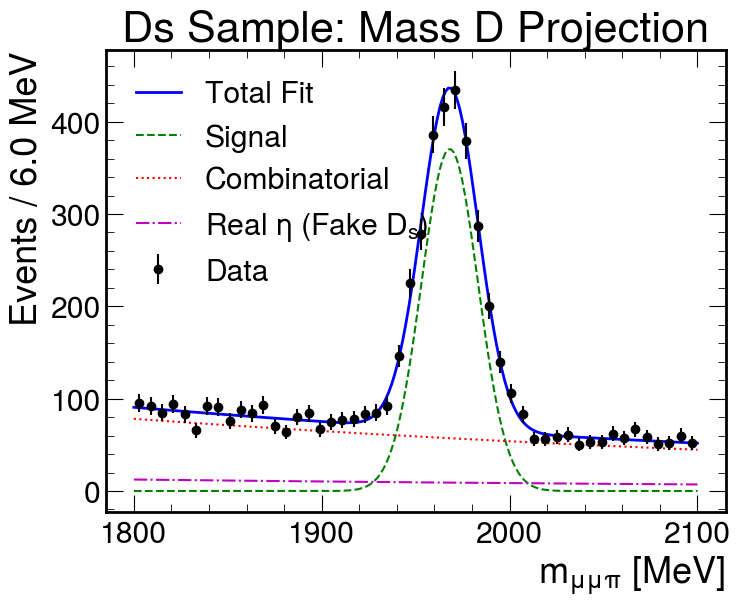

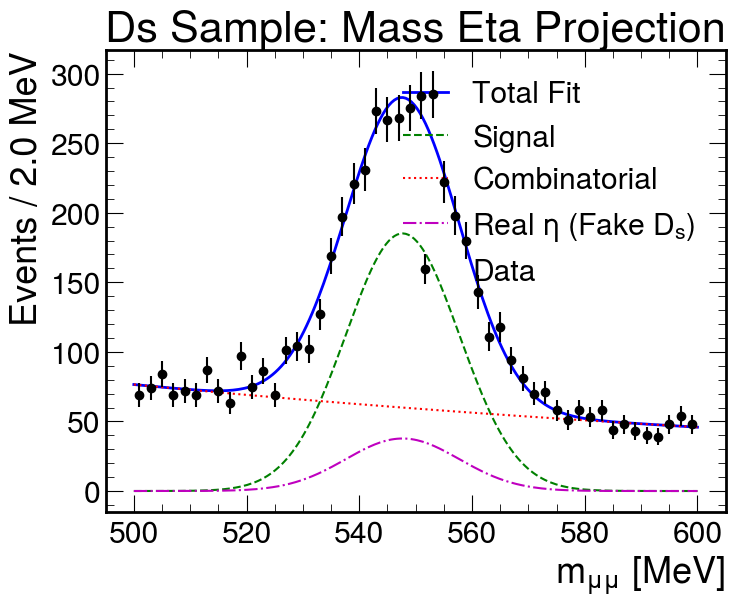

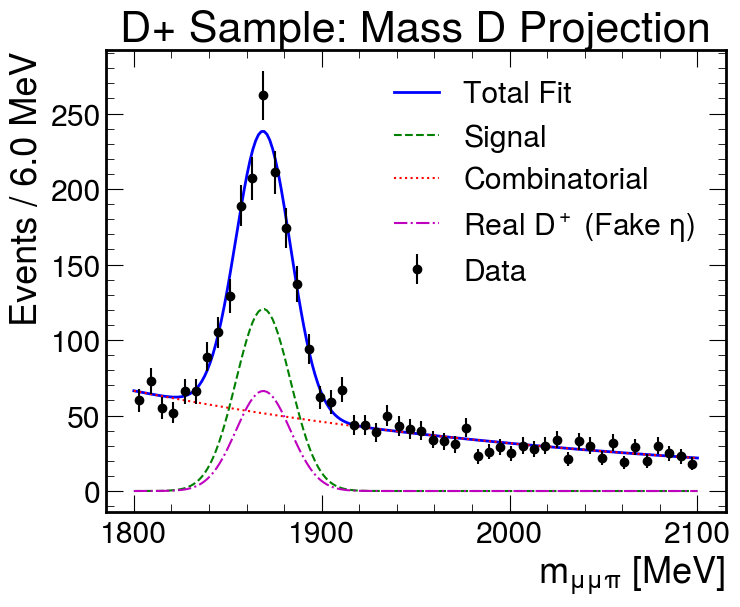

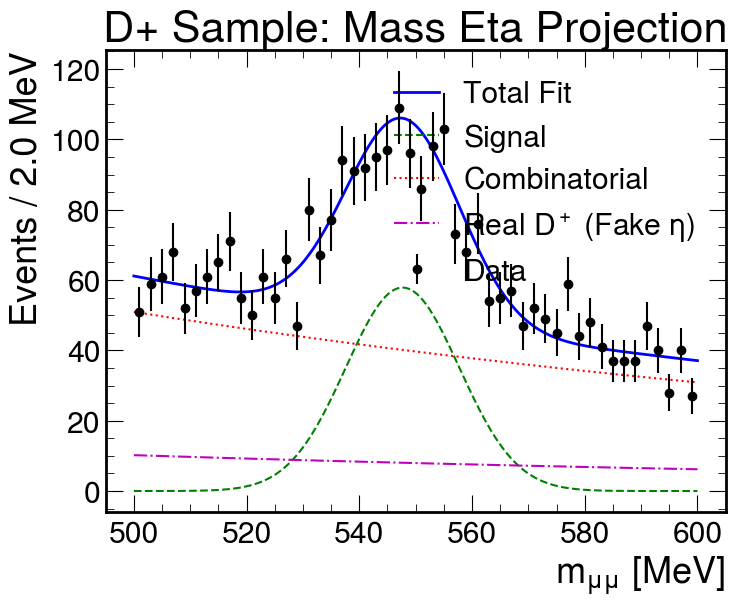

In [23]:
# ==========================================
# Plotting
# ==========================================

def plot_fit_projection(data, obs, pdf_components, yield_params, title, component_names=None, bins=50):
    """
    Manually builds a 1D model from the components to plot the projection.
    Plots all background components individually.
    """
    plt.figure(figsize=(8, 6))
    
    # 1. Data Histogram
    # Safe data access for zfit 0.20+
    obs_name = obs.obs[0]
    data_np = data.value(obs_name).numpy().flatten()
    
    lower, upper = obs.rect_limits
    xmin = float(np.array(lower).flatten()[0])
    xmax = float(np.array(upper).flatten()[0])
    
    Y, X = np.histogram(data_np, bins=bins, range=(xmin, xmax))
    X_centers = (X[1:] + X[:-1])/2
    yerr = np.sqrt(Y)
    
    plt.errorbar(X_centers, Y, yerr=yerr, fmt='ko', label="Data", zorder=10)
    
    # 2. Build 1D Model for Plotting
    # We create temporary extended PDFs for the 1D projection
    pdfs_1d_ext = []
    total_yield_val = 0
    
    for pdf, y_param in zip(pdf_components, yield_params):
        # Get scalar value of yield (handles ComposedParameter)
        y_val = float(y_param.numpy()) 
        total_yield_val += y_val
        
        # Create a temporary constant parameter for this plot
        y_const = zfit.Parameter(f"y_tmp_{np.random.randint(1e9)}", y_val, floating=False)
        pdfs_1d_ext.append(pdf.create_extended(y_const))
        
    # Sum them to get the total 1D model
    model_1d = zfit.pdf.SumPDF(pdfs_1d_ext)
    
    # 3. Evaluate and Plot Total Fit
    x_plot = np.linspace(xmin, xmax, 200)
    bin_width = (xmax - xmin) / bins
    
    y_total = model_1d.pdf(x_plot).numpy() * total_yield_val * bin_width
    plt.plot(x_plot, y_total, 'b-', linewidth=2, label="Total Fit")
    
    # 4. Plot Individual Components
    # Define styles for up to 3 components (Signal, Comb, Peaking)
    styles = ['g--', 'r:', 'm-.']
    if component_names is None:
        component_names = ["Signal", "Combinatorial", "Peaking Bkg"]

    for i, (pdf, y_param) in enumerate(zip(pdfs_1d_ext, yield_params)):
        # Calculate component PDF shape * yield * bin_width
        comp_y = pdf.pdf(x_plot).numpy() * float(y_param.numpy()) * bin_width
        
        # Select style and label
        style = styles[i % len(styles)]
        label = component_names[i] if i < len(component_names) else f"Comp {i}"
        
        plt.plot(x_plot, comp_y, style, linewidth=1.5, label=label)
    
    # 5. LaTeX Axis Labels
    if "mass_D" in obs_name:
        plt.xlabel(r"$m_{\mu\mu\pi}$ [MeV]")
    elif "mass_eta" in obs_name:
        plt.xlabel(r"$m_{\mu\mu}$ [MeV]")
    else:
        plt.xlabel(obs_name)
        
    plt.ylabel(f"Events / {bin_width:.1f} MeV")
    plt.title(title)
    plt.legend()
    plt.show()

# --- Produce Plots ---

# 1. Ds -> Mass D
# Signal (Gauss), Combinatorial (Exp), FakeDs/RealEta (Exp)
plot_fit_projection(
    data_Ds, obs_D, 
    pdf_components=[pdf_Ds_gauss, pdf_Ds_exp, pdf_Ds_exp], 
    yield_params=[n_sig_Ds, n_comb_Ds, n_fakeDs],
    component_names=["Signal", "Combinatorial", "Real $\eta$ (Fake $D_s$)"],
    title="Ds Sample: Mass D Projection"
)

# 2. Ds -> Mass Eta
# Signal (Gauss), Combinatorial (Exp), FakeDs/RealEta (Gauss)
plot_fit_projection(
    data_Ds, obs_eta, 
    pdf_components=[pdf_eta_gauss, pdf_eta_exp_Ds, pdf_eta_gauss], 
    yield_params=[n_sig_Ds, n_comb_Ds, n_fakeDs],
    component_names=["Signal", "Combinatorial", "Real $\eta$ (Fake $D_s$)"],
    title="Ds Sample: Mass Eta Projection"
)

# 3. D+ -> Mass D
# Signal (Gauss), Combinatorial (Exp), FakeEta/RealDp (Gauss)
plot_fit_projection(
    data_Dp, obs_D, 
    pdf_components=[pdf_Dp_gauss, pdf_Dp_exp, pdf_Dp_gauss], 
    yield_params=[n_sig_Dp, n_comb_Dp, n_fakeEta],
    component_names=["Signal", "Combinatorial", "Real $D^+$ (Fake $\eta$)"],
    title="D+ Sample: Mass D Projection"
)

# 4. D+ -> Mass Eta
# Signal (Gauss), Combinatorial (Exp), FakeEta/RealDp (Exp)
plot_fit_projection(
    data_Dp, obs_eta, 
    pdf_components=[pdf_eta_gauss, pdf_eta_exp_Dp, pdf_eta_exp_Dp], 
    yield_params=[n_sig_Dp, n_comb_Dp, n_fakeEta],
    component_names=["Signal", "Combinatorial", "Real $D^+$ (Fake $\eta$)"],
    title="D+ Sample: Mass Eta Projection"
)